In [ ]:
import re
from pyvi import ViTokenizer
import pandas as pd

class DataPreprocessing:
    def __init__(self, text, acronyms_file, stopwords_file):
        self.text = text
        self.stopwords = self.load_stopwords(stopwords_file)
        self.acronyms = self.load_acronyms(acronyms_file)

    def load_acronyms(self, filename):
        """Tải danh sách từ viết tắt từ file."""
        acronyms = []
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split(maxsplit=1)  # Tách bằng khoảng trắng đầu tiên
                    if len(parts) == 2:
                        acronyms.append((parts[0].strip(), parts[1].strip()))
        except FileNotFoundError:
            print(f"File {filename} không tồn tại.")
        return acronyms

    def load_stopwords(self, filename):
        """Tải danh sách từ dừng từ file."""
        stopwords = set()
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                for line in f:
                    stopwords.add(line.strip())
        except FileNotFoundError:
            print(f"File {filename} không tồn tại.")
        return stopwords
    
    def remove_punctuation(self, text):
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def segmentation(self):
        return ViTokenizer.tokenize(self.text)

    def split_words(self):
        text = self.segmentation()
        try:
            special_characters = '.,!?;:"\'()[]{}<>-'
            cleaned_words = [x.strip(special_characters).lower() for x in text.split()]
            return [self.remove_punctuation(word) for word in cleaned_words]
        except TypeError:
            return []

    def remove_loop_char(self):
        self.text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), str(self.text), flags=re.IGNORECASE)
        self.text = re.sub(r'[^A-Za-zÀ-ỹ\s]', ' ', self.text)
        return self.text
        
    def replace_acronyms(self):
        """Thay thế các từ viết tắt."""
        list_text = self.text.split(" ")
        for i in range(len(list_text)):
            for acronym in self.acronyms:
                if list_text[i] == acronym[0]:
                    list_text[i] = acronym[1]
        self.text = " ".join(list_text)
        return self.text

    def remove_stopwords(self):
        split_words = self.split_words()
        words = []

        for word in split_words:
            if word not in self.stopwords:
                words.append(word)

        return ' '.join(words)

    def preprocess(self):
        self.text = self.remove_loop_char()
        self.text = self.replace_acronyms()
        self.text = self.remove_stopwords()
        return self.text

# Đường dẫn tới tệp CSV
csv_file = './datasets.csv'  # Thay đổi tên tệp này theo tệp của bạn
acronyms_file = './acronym_vi.txt'  # Đường dẫn tới tệp từ viết tắt
stopwords_file = './stopwords-nlp-vi.txt'  # Đường dẫn tới tệp từ dừng

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv(csv_file)

# Chuẩn hóa nội dung
df['content'] = df['content'].apply(lambda x: DataPreprocessing(x, acronyms_file, stopwords_file).preprocess())
df['category'] = df['category']  # Giữ nguyên cột category 

# Lưu kết quả vào tệp CSV mới
df[['content', 'category']].to_csv('output_processed.csv', index=False, encoding='utf-8-sig')

In [2]:
# In thông tin của csv đã được tiền xử lý dữ liệu
output_csv_file = 'output_processed.csv' 

# Đọc dữ liệu từ tệp CSV
df_processed = pd.read_csv(output_csv_file)

# In thông tin từ DataFrame
print(df_processed.info())  
print(df_processed.head())   
print(df_processed.describe())   


unique_categories = df_processed['category'].unique()
print(unique_categories)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607 entries, 0 to 2606
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   2607 non-null   object
 1   category  2607 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB
None
                                             content    category
0  cá_nhân_hóa trải nghiệm công_nghệ tiên_tiến ng...  Apps/Games
1  microsoft ra_mắt ofice ofice chính_thức ra_mắt...  Apps/Games
2  thành_tựu black myth wukong youtube ải nếu_như...  Apps/Games
3  tựa trò_chơi đắt steam mua nội_dung tốn triệu ...  Apps/Games
4  ceo game science trả_lời hài_hước khả_năng bla...  Apps/Games
                                                  content category
count                                                2607     2607
unique                                               2607        5
top     cá_nhân_hóa trải nghiệm công_nghệ tiên_tiến ng...  Tin ICT
freq                                  

In [3]:
# # =====================================
# =====================================
# Vector hóa văn bản
# =====================================
# =====================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

csv_file_path = './output_processed.csv'

df = pd.read_csv(csv_file_path)

# Đếm số lượng bản ghi cho mỗi lớp trong cột 'category'
record_counts = df['category'].value_counts()
print(record_counts)

X = df['content']
y = df['category']

# Kiểm tra các giá trị missing trong DataFrame
# missing_values = df.isnull().sum()
# print("Missing values:")
# print(missing_values)

# ====================================================
# Điều chỉnh tham số vector hóa
vectorizer = TfidfVectorizer(
    # max_features=1000,  # Tăng số đặc trưng
    ngram_range=(1, 3),  # Bao gồm cả trigram
    max_df=0.5,
    min_df=3,
    sublinear_tf=True,
    use_idf=True,
)
X_tfidf = vectorizer.fit_transform(X)

# Lưu vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
# ====================================================

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Đếm số lượng bản ghi trong X_train và X_test
num_records_train = X_train.shape[0]
num_records_test = X_test.shape[0]

print(f"Số lượng bản ghi trong X_train: {num_records_train}")
print(f"Số lượng bản ghi trong X_test: {num_records_test}")

# Chuyển đổi nhãn lớp thành số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Kiểm tra kích thước
print(f"Kích thước X_train: {X_train.shape}"    )
print(f"Kích thước X_test: {X_test.shape}")
print(f"Số lớp trong y_train: {len(set(y_train))}")

category
Tin ICT       559
Internet      523
Mobile        519
Apps/Games    513
Xe            493
Name: count, dtype: int64
Số lượng bản ghi trong X_train: 2085
Số lượng bản ghi trong X_test: 522
Kích thước X_train: (2085, 4573)
Kích thước X_test: (522, 4573)
Số lớp trong y_train: 5


# SVM

Model: SVM
Accuracy: 0.7280
F1 Score: 0.7388
Recall: 0.7324
Precision: 0.7479
Confusion Matrix:


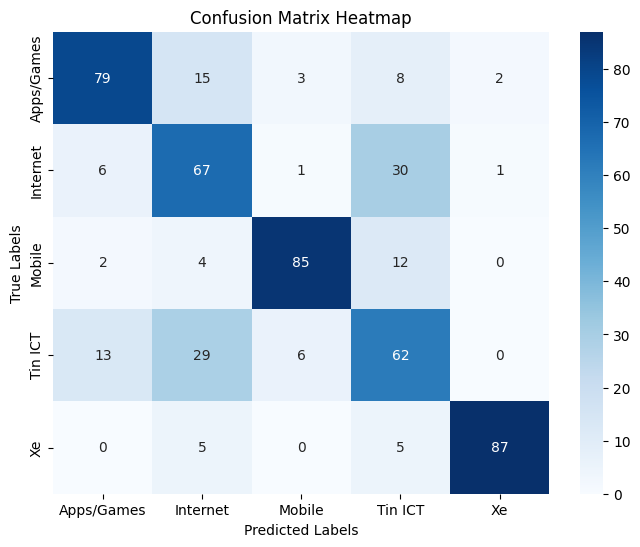

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def train_svm(X_train, y_train, X_test, y_test, label_encoder):
    # Tìm tham số tốt nhất
    # Define the SVM model
    # svm = SVC()

    # # Define a grid of hyperparameters to search
    # param_grid = {
    #     'C': [0.1, 1, 10, 100],
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'degree': [2, 3, 4]  # Only used when kernel is 'poly'
    # }

    # # Perform grid search with cross-validation
    # grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
    # grid_search.fit(X_train, y_train)

    # # Get the best hyperparameters from the grid search
    # best_params = grid_search.best_params_
    # best_score = grid_search.best_score_

    # print("Best Hyperparameters:", best_params)
    # print("Best Cross-Validation Score:", best_score)

    # # Train an SVM model with the best hyperparameters on the full training set
    # model = SVC(**best_params)


    # ====================================
    # ====================================
    # ====================================

    # Huấn luyện mô hình
    
    # Khởi tạo mô hình SVM
    model = SVC(C=10, degree=2, kernel='rbf', random_state=42)

    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính toán các chỉ số đánh giá
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Chỉ số F1, Recall, Precision cho lớp chính
    f1 = report['macro avg']['f1-score']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    
    # In ra kết quả
    print("Model: SVM")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:")

    unique_categories = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_categories, yticklabels=unique_categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

    # Lưu mô hình
    with open('svm_model.pkl', 'wb') as file:
        pickle.dump(model, file)

    return model

trained_model = train_svm(X_train, y_train, X_test, y_test, label_encoder)

In [12]:
def predict_svm(model, vectorizer, text):
    # Chuyển đổi văn bản thành vector bằng vectorizer đã được huấn luyện
    text_vector = vectorizer.transform([text])

    # Dự đoán lớp cho văn bản
    prediction = model.predict(text_vector)

    return prediction[0]

Predict

In [13]:
classes = ['Apps/Games', 'Internet', 'Mobile', 'Tin ICT', 'Xe']
text_input = "Mazda5 ra mắt gần đây"
prediction = predict_svm(trained_model, vectorizer, text_input)
print(f"Dự đoán lớp: { classes[prediction] }")

Dự đoán lớp: Internet


# KNN 

Model: KNN
Accuracy: 0.6992
F1 Score: 0.6984
Recall: 0.7041
Precision: 0.6995
Confusion Matrix:


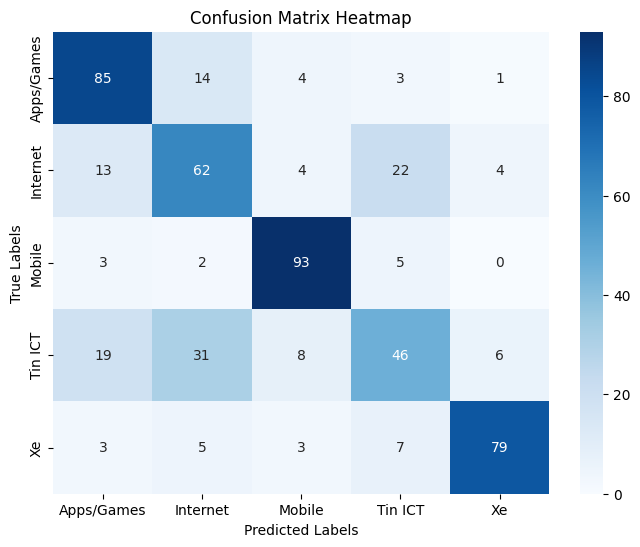

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

def train_knn(X_train, y_train, X_test, y_test, label_encoder, n_neighbors=20):
    # Khởi tạo mô hình KNN
    model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính toán các chỉ số đánh giá
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Chỉ số F1, Recall, Precision cho lớp chính
    f1 = report['macro avg']['f1-score']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    
    # In ra kết quả
    print("Model: KNN")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:")

    unique_categories = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_categories, yticklabels=unique_categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

    # Lưu mô hình
    with open('knn_model.pkl', 'wb') as file:
        pickle.dump(model, file)


    return model

# Ví dụ cách gọi hàm với dữ liệu
trained_model_knn = train_knn(X_train, y_train, X_test, y_test, label_encoder, n_neighbors=5)


# =================================
# Tìm K
# Tìm K
# Tìm K
# Tìm K
# Tìm K
# Tìm K
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt

# def find_best_k(X_train, y_train, X_test, y_test, max_k=30):
#     accuracies = []

#     # Lặp qua các giá trị k khác nhau
#     for k in range(1, max_k + 1):
#         model = KNeighborsClassifier(n_neighbors=k)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test, y_pred)
#         accuracies.append(acc)
#         print(f"k={k}, Accuracy={acc:.4f}")

#     # Tìm giá trị k tốt nhất với độ chính xác cao nhất
#     best_k = accuracies.index(max(accuracies)) + 1
#     best_accuracy = max(accuracies)
#     print(f"Best k: {best_k} với độ chính xác: {best_accuracy:.4f}")

#     # Vẽ biểu đồ độ chính xác cho từng k
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, max_k + 1), accuracies, marker='o', linestyle='-')
#     plt.xlabel('Số lượng láng giềng (k)')
#     plt.ylabel('Độ chính xác')
#     plt.title('Độ chính xác theo số lượng láng giềng (k)')
#     plt.xticks(range(1, max_k + 1))
#     plt.show()

#     return best_k

# # Cách sử dụng với dữ liệu của bạn
# best_k = find_best_k(X_train, y_train, X_test, y_test)



# Naive Bayes 

Model: Naive Bayes
Accuracy: 0.7299
F1 Score: 0.7344
Recall: 0.7357
Precision: 0.7332
Confusion Matrix:


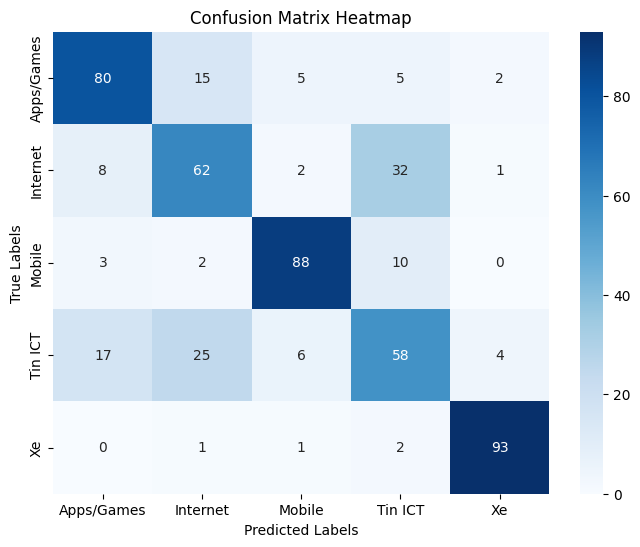

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

def train_naive_bayes(X_train, y_train, X_test, y_test, label_encoder):
    # Khởi tạo mô hình Naive Bayes
    model = MultinomialNB()

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính toán các chỉ số đánh giá
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Chỉ số F1, Recall, Precision cho lớp chính
    f1 = report['macro avg']['f1-score']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    
    # In ra kết quả
    print("Model: Naive Bayes")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:")

    unique_categories = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_categories, yticklabels=unique_categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

    # Lưu mô hình
    with open('bayes_model.pkl', 'wb') as file:
        pickle.dump(model, file)


    return model

# Ví dụ cách gọi hàm với dữ liệu
trained_model_nb = train_naive_bayes(X_train, y_train, X_test, y_test, label_encoder)


In [23]:
# # =====================================
# # =====================================
# # Biến đổi chuỗi json thành csv
# # =====================================
# # =====================================


# import pandas as pd
# import json
# import csv

# def json_to_csv(json_file, csv_file):
#     # Đọc dữ liệu từ tệp JSON
#     with open(json_file, 'r', encoding='utf-8') as f:
#         data = json.load(f)

#     # Chuyển đổi dữ liệu JSON thành DataFrame
#     df = pd.json_normalize(data)

#     # Tạo trường mới là nối title và subtitle
#     df['content'] = df['title'] + " " + df['subtitle']

#    # Chọn các cột cần thiết
#     result_df = df[['content', 'category']]

#     # Lọc các hàng có category thuộc danh sách mong muốn
#     categories_to_keep = ['Apps/Games', 'Internet', 'Mobile', 'Tin ICT', 'Xe']
#     filtered_df = result_df[result_df['category'].isin(categories_to_keep)]

#     # Loại bỏ các dòng trùng lặp dựa trên cột 'content'
#     filtered_df = filtered_df.drop_duplicates(subset='content')

#     # Ghi DataFrame vào tệp CSV
#     filtered_df.to_csv(csv_file, index=False, encoding='utf-8-sig')


# # Đường dẫn tới tệp JSON và tệp CSV mong muốn
# json_file_path = './datasets.json'  # Thay thế bằng đường dẫn tệp JSON của bạn
# csv_file_path = './datasets.csv'     # Thay thế bằng đường dẫn tệp CSV bạn muốn tạo

# # Gọi hàm chuyển đổi
# json_to_csv(json_file_path, csv_file_path)

# print(f"Đã chuyển đổi {json_file_path} thành {csv_file_path}")
